In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0


In [3]:
import os
import cv2

dataset_path = r"DATASET-20251202T142134Z-1-001/DATASET"

classes = os.listdir(dataset_path)
print("Classes found:", classes)

data = []
labels = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                data.append(img)
                labels.append(cls)

print("Total images loaded:", len(data))

Classes found: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']
Total images loaded: 1203


In [4]:
from collections import Counter

class_counts = Counter(labels)  

print(class_counts)


Counter({'dark spots': 303, 'clear skin': 300, 'puffy eyes': 300, 'wrinkles': 300})


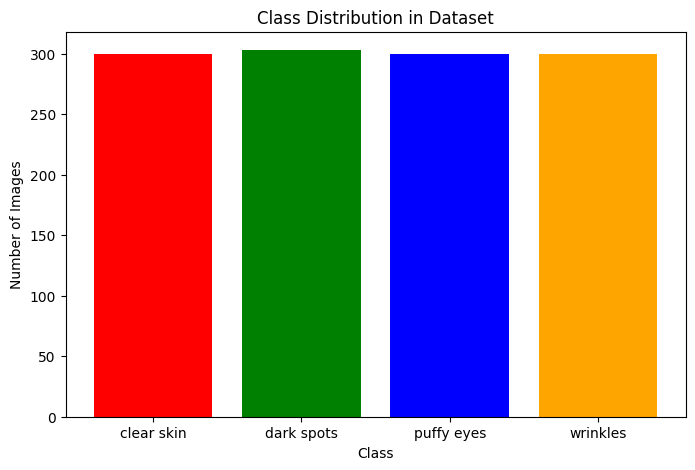

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
colors = ['red', 'green', 'blue', 'orange']  
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [7]:
import cv2
import numpy as np

IMG_SIZE = 224
processed_images = []

for img in data: 
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    normalized = resized / 255.0
    processed_images.append(normalized)

processed_images = np.array(processed_images)

print("Processed images shape:", processed_images.shape)


Processed images shape: (1203, 224, 224, 3)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,     
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.2,        
    horizontal_flip=True,  
    fill_mode='nearest'
)


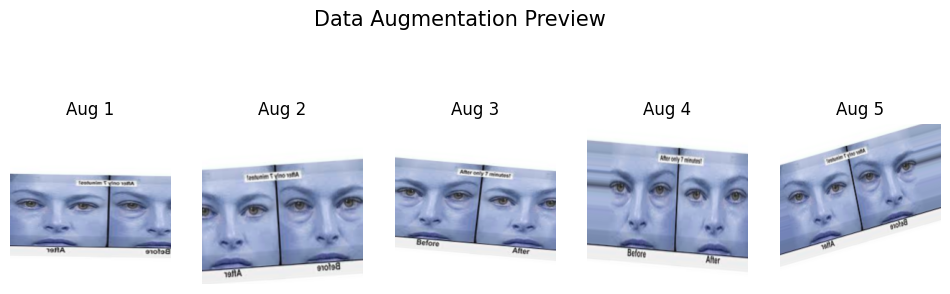

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

random_index = random.randrange(len(processed_images))
selected_image = processed_images[random_index]

# Prepare image for augmentation
image_array = np.expand_dims(selected_image, axis=0)

# Generate 5 augmented versions
augmented_batch = [next(datagen.flow(image_array))[0] for _ in range(5)]

# Plot results
plt.figure(figsize=(12, 4))

for i, img in enumerate(augmented_batch):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Aug {i+1}")

plt.suptitle("Data Augmentation Preview", fontsize=15)
plt.show()


In [10]:
print("Unique labels:", set(labels))
print("Classes:", classes)


Unique labels: {'puffy eyes', 'clear skin', 'dark spots', 'wrinkles'}
Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [11]:
from tensorflow.keras.utils import to_categorical


label_map = {cls: i for i, cls in enumerate(classes)}
print("Label Mapping:", label_map)


numeric_labels = [label_map[label] for label in labels]


num_classes = len(classes)
labels_one_hot = to_categorical(numeric_labels, num_classes)

print("One-hot encoded shape:", labels_one_hot.shape)
print(labels_one_hot[:5])


Label Mapping: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}
One-hot encoded shape: (1203, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    processed_images,
    labels_one_hot,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Training shape: (962, 224, 224, 3)
Validation shape: (241, 224, 224, 3)


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [14]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,222,055 (16.11 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2412 - loss: 1.4121 - val_accuracy: 0.2199 - val_loss: 1.3885
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2630 - loss: 1.3976 - val_accuracy: 0.2614 - val_loss: 1.3977
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2744 - loss: 1.3962 - val_accuracy: 0.2573 - val_loss: 1.3896
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2547 - loss: 1.3889 - val_accuracy: 0.2199 - val_loss: 1.3880
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2443 - loss: 1.3919 - val_accuracy: 0.2614 - val_loss: 1.3856
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2443 - loss: 1.3918 - val_accuracy: 0.2573 - val_loss: 1.3851
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2557 - loss: 1.3889 - val_accuracy: 0.2614 - val_loss: 1.3853


In [18]:
model.save("skin_aging_model.h5")
print("Model saved as skin_aging_model.h5")


Model saved as skin_aging_model.h5


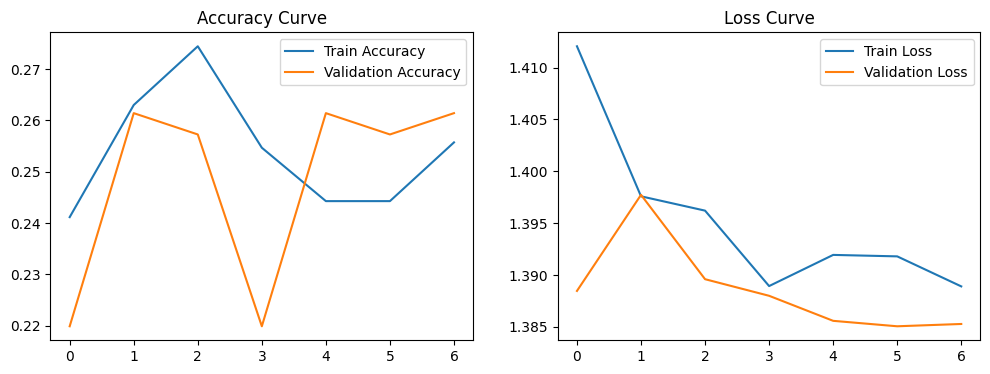

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()


In [20]:
import cv2
import numpy as np
import os
import random


In [21]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


In [22]:
def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (224, 224))
    face_img = face_img / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    return face_img


In [23]:
problem_names = {
    "clear skin": "Healthy / Clear Skin",
    "puffy eyes": "Puffy Eyes",
    "dark spots": "Dark Spots / Pigmentation",
    "wrinkles": "Wrinkles & Fine Lines"
}


In [24]:
def estimate_age(class_name):
    if class_name == "clear skin":
        return "18-25"
    elif class_name == "puffy eyes":
        return "25-35"
    elif class_name == "dark spots":
        return "35-45"
    elif class_name == "wrinkles":
        return "45+"


In [25]:
def predict_aging_clean(image_path):

    img = cv2.imread(image_path)
    if img is None:
        print("❌ Image not found!")
        return

    # Convert for detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=4,
        minSize=(80, 80)
    )

    # If no face detected, use whole image as fallback
    if len(faces) == 0:
        face = img.copy()
        processed_face = preprocess_face(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        preds = model.predict(processed_face)[0]

        idx = np.argmax(preds)
        skin_label = classes[idx]
        skin_conf = preds[idx] * 100
        age_range = estimate_age(skin_label)

        text_skin = f"{skin_label} {skin_conf:.1f}%"
        text_age = f"Age: {age_range}"

        # Smaller font
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2

        # Put text inside top-left
        cv2.putText(img, text_skin, (10, 30), font, font_scale, (0, 255, 0), thickness)
        cv2.putText(img, text_age, (10, 55), font, font_scale, (0, 255, 0), thickness)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()
        return

    # For each detected face
    for (x, y, w, h) in faces:
        face_region = img[y:y+h, x:x+w]
        processed_face = preprocess_face(cv2.cvtColor(face_region, cv2.COLOR_BGR2RGB))
        preds = model.predict(processed_face)[0]

        idx = np.argmax(preds)
        skin_label = classes[idx]
        skin_conf = preds[idx] * 100
        age_range = estimate_age(skin_label)

        text_skin = f"{skin_label} {skin_conf:.1f}%"
        text_age = f"Age: {age_range}"

        # Draw green bounding box
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

        # Smaller text inside the box region near top-left
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2

        cv2.putText(img, text_skin, (x+5, y+20), font, font_scale, (0, 255, 0), thickness)
        cv2.putText(img, text_age, (x+5, y+40), font, font_scale, (0, 255, 0), thickness)

    # Show final image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


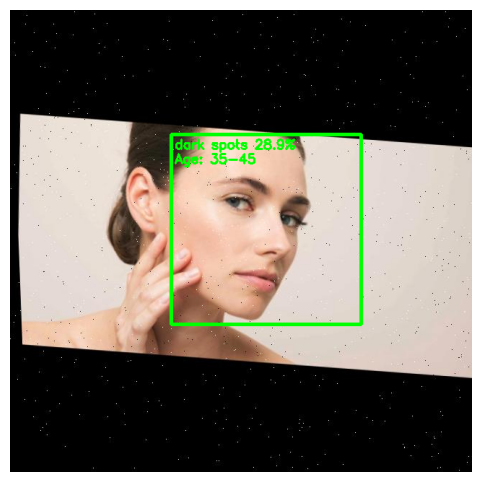

In [30]:
dataset_root = r"DATASET-20251202T142134Z-1-001/DATASET"

cls = random.choice(os.listdir(dataset_root))
img_name = random.choice(os.listdir(os.path.join(dataset_root, cls)))
test_image = os.path.join(dataset_root, cls, img_name)

predict_aging_clean(test_image)
